<a href="https://colab.research.google.com/github/Kate-Strydom/cse450/blob/main/house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import 

In [ ]:
#from sys import platform

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost

#from sklearn import preprocessing, model_selection, ensemble, metrics, pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle


In [ ]:
# disable scientific notation
pd.set_option('display.float_format', lambda x: '%.9f' % x)
# reset
#pd.reset_option('display.float_format', silent=True)

## Data Preprocessing 

In [ ]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
# data is from 2010 -2014
# inflation between 2014 and 2015 hardly changed.
zipcode = pd.read_csv('https://raw.githubusercontent.com/Kate-Strydom/cse450/main/notebooks/zipcode_washington.csv')

# merge data on zipcodes
data_merged = housing.merge(zipcode, left_on='zipcode', right_on='zipcode')
#print(housing.info())
#print(zipcode.info())
#print(housing.head())
#print(zipcode.head())
#print(data.head())
#print(data.describe())
#print(data.info())
# number of observations 
len(data_merged.index)

20000

## Data Wrangling

### Formating Features

In [ ]:
# remove timestamp on data
data_merged['date'] = pd.to_datetime(data_merged['date'])
data_merged.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income
0,1565930130,2014-11-04,4,3.250000000,3760,4675,2.000000000,0,0,3,...,2007,0,98038,47.386200000,-122.048000000,3280,4033,429900.000000000,34076,93573
1,6699940320,2015-04-13,4,2.500000000,2600,5188,2.000000000,0,0,3,...,2005,0,98038,47.345100000,-122.040000000,2610,5188,359900.000000000,34076,93573
2,5416500260,2014-09-08,3,2.500000000,1890,3629,2.000000000,0,0,3,...,2005,0,98038,47.361300000,-122.041000000,1980,4000,285000.000000000,34076,93573
3,1442700430,2014-08-08,5,2.500000000,3180,23809,1.000000000,0,0,3,...,1978,0,98038,47.372700000,-122.054000000,2500,15778,499950.000000000,34076,93573
4,522069119,2015-05-12,3,2.500000000,2720,62310,1.000000000,0,0,3,...,1985,0,98038,47.416800000,-122.074000000,2770,204296,550000.000000000,34076,93573


## New Features

William, The VP of Finance: "Our insurance customers are particularly interested in making sure that homes in unsavory neighborhoods, are not estimated high.
Question: Is there a way we can easily identify properties in lower income areas and have the model lower those estimates  to protect our insurance customers' interests?

Text(0.5, 0, 'Median Household Income')

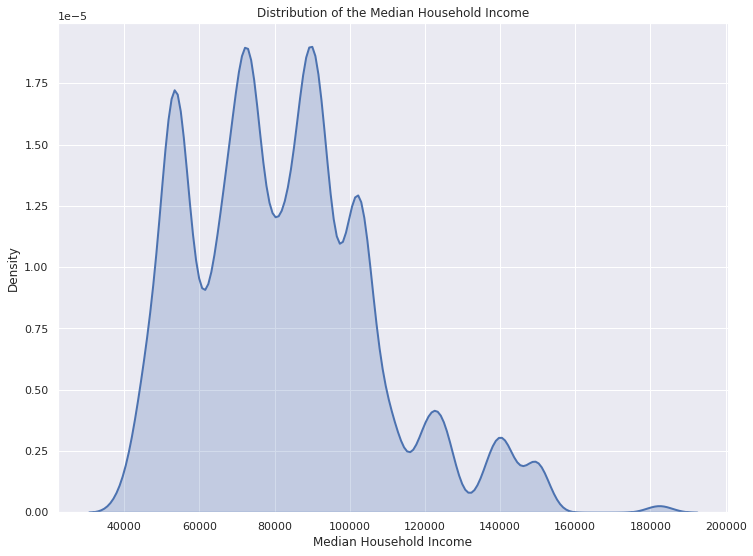

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=data_merged['median_household_income'], shade=True, linewidth=2)
ax.set_title("Distribution of the Median Household Income")
ax.set_xlabel("Median Household Income")

In [ ]:
# create an adjusted median_household income feature. Assign arbitary values

def lowIncome(income):
    if income >=  80000:
        return income
    elif (income < 80000) & (income >= 65000):
       return income * 0.80
    else:
        return income * 0.70

In [ ]:
data_merged['adjusted_median_household_income'] = data_merged['median_household_income'].apply(lowIncome)
#data_merged.head(20)

In [ ]:
data_merged.adjusted_median_household_income.sort_values()

16466    28459.200000000
16498    28459.200000000
16499    28459.200000000
16500    28459.200000000
16501    28459.200000000
              ...       
19872   182308.000000000
19873   182308.000000000
19874   182308.000000000
19876   182308.000000000
19892   182308.000000000
Name: adjusted_median_household_income, Length: 20000, dtype: float64

Text(0.5, 0, 'Adjusted Median Household Income')

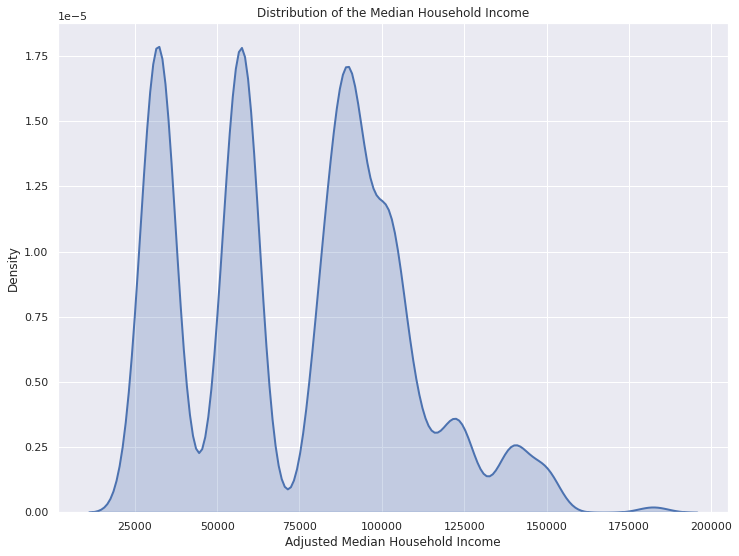

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=data_merged['adjusted_median_household_income'], shade=True, linewidth=2)
ax.set_title("Distribution of the Median Household Income")
ax.set_xlabel("Adjusted Median Household Income")

### Remove outliers

Outliers - bedrooms, sqft_lot, sqft_living and price as the mean is being pulled towards the extreme values

In [ ]:
# remove extreme values 
data = data_merged[(data_merged['bedrooms'] < 33)  & (data_merged['sqft_lot'] < 1000000) & (data_merged['sqft_living'] < 13540) & (data_merged['price'] < 3000000)]
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income,adjusted_median_household_income
count,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,...,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000,19950.000000000
mean,4580361019.432129860,3.365864662,2.110075188,2069.959498747,14821.220050125,1.495538847,0.006616541,0.229674185,3.409573935,7.649122807,...,82.337894737,98077.963007519,47.559817303,-122.213933133,1982.499097744,12721.328170426,531854.669624060,31919.053984962,82250.618045113,74954.190486213
std,2874781167.145298481,0.905382777,0.759079580,891.292462726,37439.811039624,0.540555509,0.081074609,0.756002030,0.651691306,1.161737729,...,396.960842066,53.434857623,0.138626892,0.140716083,680.368516567,27062.011957872,326572.517687387,11500.212840419,24438.128409077,30824.968009214
min,1000102.000000000,0.000000000,0.000000000,290.000000000,520.000000000,1.000000000,0.000000000,0.000000000,1.000000000,1.000000000,...,0.000000000,98001.000000000,47.155900000,-122.519000000,399.000000000,651.000000000,75000.000000000,3080.000000000,40656.000000000,28459.200000000
25%,2123049439.500000000,3.000000000,1.750000000,1425.500000000,5033.250000000,1.000000000,0.000000000,0.000000000,3.000000000,7.000000000,...,0.000000000,98033.000000000,47.470200000,-122.329000000,1481.000000000,5100.000000000,321000.000000000,22772.000000000,65321.000000000,52256.800000000
50%,3904980150.000000000,3.000000000,2.250000000,1910.000000000,7609.500000000,1.500000000,0.000000000,0.000000000,3.000000000,7.000000000,...,0.000000000,98065.000000000,47.571150000,-122.230500000,1840.000000000,7620.000000000,450000.000000000,31778.000000000,81037.000000000,81037.000000000
75%,7309050175.000000000,4.000000000,2.500000000,2540.000000000,10651.500000000,2.000000000,0.000000000,0.000000000,4.000000000,8.000000000,...,0.000000000,98117.000000000,47.678100000,-122.124000000,2360.000000000,10073.250000000,640000.000000000,40610.000000000,93573.000000000,93573.000000000
max,9900000190.000000000,11.000000000,7.500000000,8670.000000000,982998.000000000,3.500000000,1.000000000,4.000000000,5.000000000,13.000000000,...,2015.000000000,98199.000000000,47.777600000,-121.315000000,6210.000000000,871200.000000000,2998000.000000000,60920.000000000,182308.000000000,182308.000000000


### Correlation

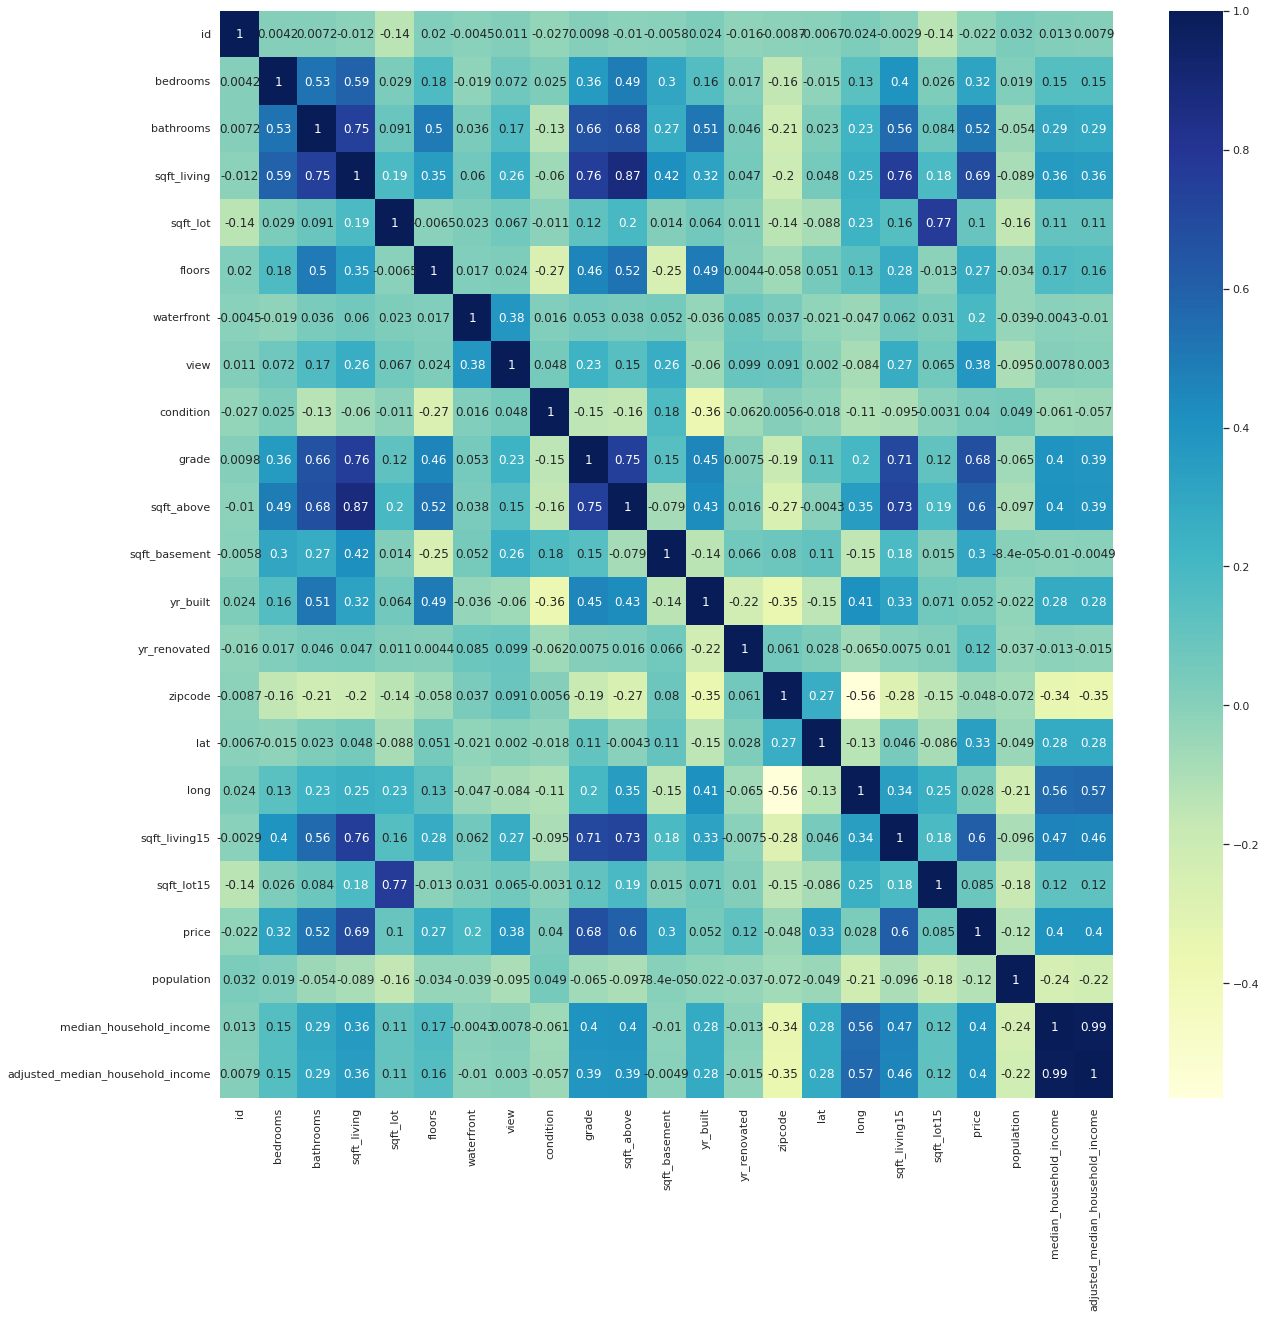

In [ ]:
data.corr()

sns.set(rc = {'figure.figsize':(20,20)})

# plotting correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

Price has the highest positive correlation with grade followed by sqft_living. But grading and sqft_living are both highly correlated with each other. 

In [ ]:
# filter only sqft_living and price
df = data.loc[:, ['sqft_living', 'price']]
df.head()
min_sqft_living = df['sqft_living'].min()
print("Min sqft living: %d sq feet"  % (min_sqft_living))
max_sqft_living = df['sqft_living'].max()
print("Max sqft living: %d sq feet"  % (max_sqft_living))

Min sqft living: 290 sq feet
Max sqft living: 8670 sq feet


In [ ]:
# recaling the variables (both)
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,sqft_living,price
0,0.414081146,0.121416353
1,0.275656325,0.097468354
2,0.190930788,0.071843996
3,0.344868735,0.145381457
4,0.289976134,0.162504276


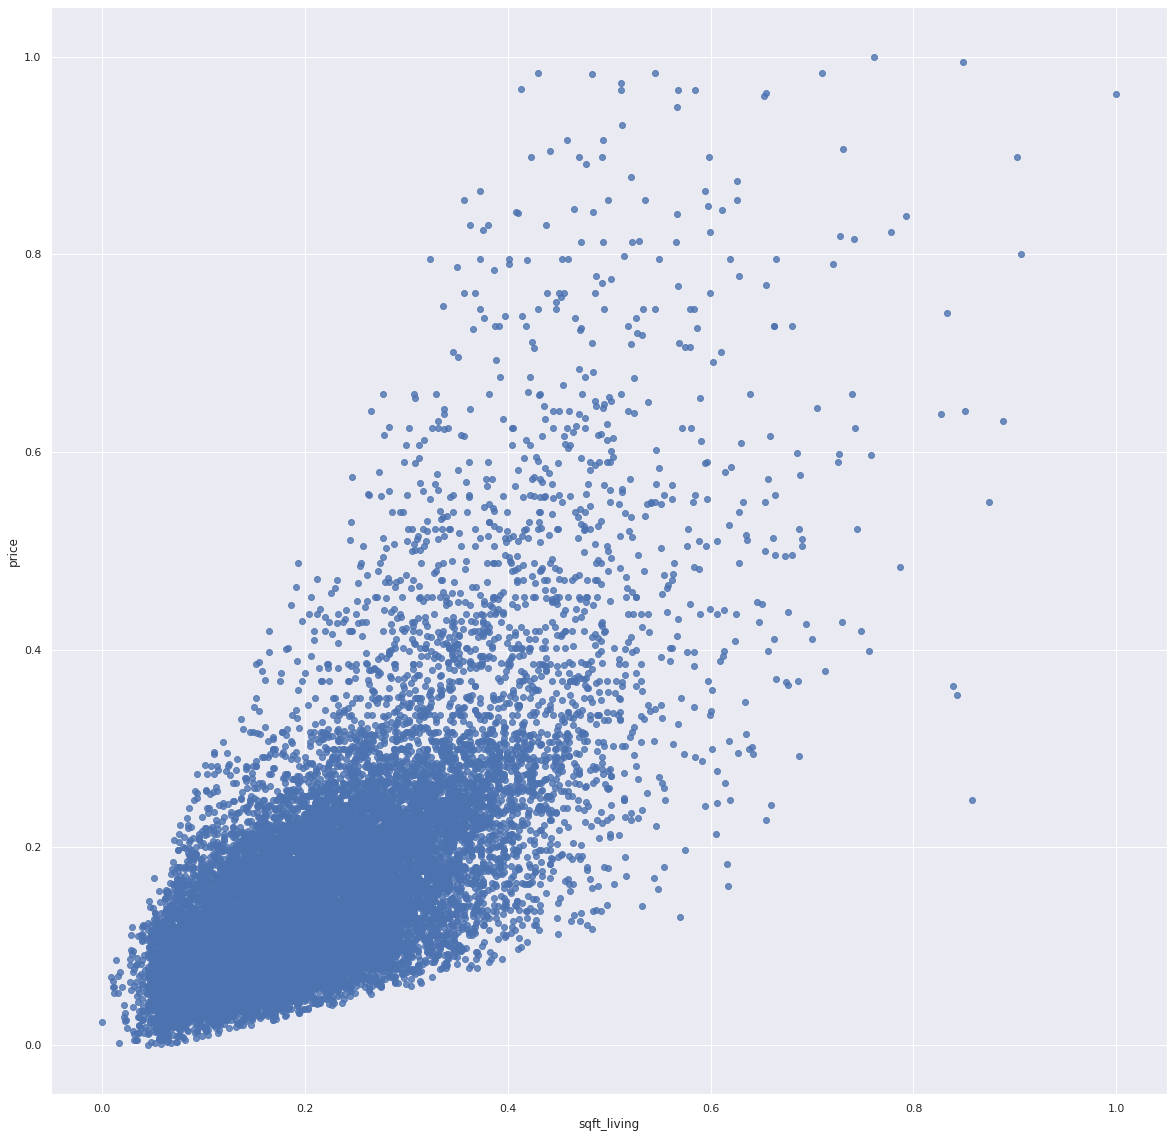

In [ ]:
# visualise sqft_living-price relationship
sns.regplot(x="sqft_living", y="price", data=df, fit_reg=False)

In [ ]:
# train-test 70-30 split
df_train, df_test = train_test_split(data, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 85)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',  'yr_renovated',  'adjusted_median_household_income']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income,adjusted_median_household_income
13600,8632100010,2014-06-04,0.222222222,0.133333333,0.116000000,0.007662664,0.000000000,0.000000000,0,4,...,0.000000000,98125,47.729400000,-122.329000000,1710,8100,365000.000000000,37560,52353,0.053220435
3574,917000300,2014-05-20,0.444444444,0.133333333,0.110666667,0.003245028,0.200000000,0.000000000,0,3,...,0.000000000,98103,47.687200000,-122.344000000,1540,3800,452000.000000000,47559,76925,0.215021502
12828,3278613060,2014-08-05,0.444444444,0.333333333,0.202666667,0.002233247,0.400000000,0.000000000,0,3,...,0.000000000,98106,47.543000000,-122.368000000,1900,2604,425000.000000000,25023,53949,0.060482110
16422,3830210230,2015-03-19,0.333333333,0.133333333,0.109333333,0.006766922,0.000000000,0.000000000,0,3,...,0.000000000,98030,47.374600000,-122.183000000,1200,7200,225205.000000000,35302,52297,0.052965639
13728,6414100560,2014-06-18,0.333333333,0.233333333,0.176000000,0.008000603,0.000000000,0.000000000,0,3,...,0.000000000,98125,47.722100000,-122.317000000,1800,7842,475000.000000000,37560,52353,0.053220435


In [ ]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,population,median_household_income,adjusted_median_household_income
10553,426059055,2014-10-03,0.272727273,0.269230769,0.252983294,0.041191805,0.000000000,0.000000000,0,0.500000000,...,0.993052109,98072,47.765100000,-122.166000000,0.288201161,0.038647149,620000.000000000,0.335494467,107009,0.510564918
1366,6021502070,2015-05-08,0.181818182,0.153846154,0.133651551,0.004722416,0.000000000,0.000000000,0,0.500000000,...,0.000000000,98117,47.688300000,-122.384000000,0.131528046,0.009095257,600000.000000000,0.496161826,91199,0.407801686
7268,9286100300,2014-08-01,0.272727273,0.384615385,0.164677804,0.004494601,0.400000000,0.000000000,0,0.500000000,...,0.000000000,98027,47.530700000,-122.047000000,0.203094778,0.005299450,483500.000000000,0.416096127,102760,0.482946893
14949,5366200330,2015-01-14,0.363636364,0.307692308,0.144391408,0.003724538,0.000000000,0.000000000,0,0.500000000,...,0.000000000,98122,47.608800000,-122.293000000,0.181818182,0.007215113,470000.000000000,0.535511757,55725,0.068562771
4872,4038500330,2015-04-07,0.272727273,0.269230769,0.150357995,0.009034290,0.000000000,0.000000000,0,0.750000000,...,0.000000000,98008,47.613600000,-122.121000000,0.143133462,0.017383047,432000.000000000,0.369502075,88862,0.392611447


apply log transformation for y_train and y_test

In [ ]:
# apply log transformation to the train price
df_train['logprice'] = np.log(df_train['price'])
#print(df_train.head())

Text(0.5, 0, 'Price of Houses')

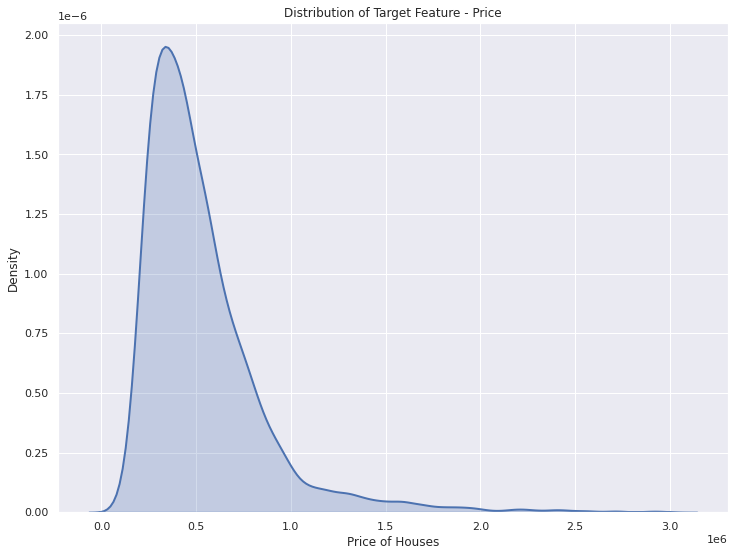

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=df_train['price'], shade=True, linewidth=2)
ax.set_title("Distribution of Target Feature - Price")
ax.set_xlabel("Price of Houses")

In [ ]:
# apply log transformation on test data price
df_test['logprice'] = np.log(df_test['price'])
#print(df_test.head())

Text(0.5, 0, 'Log Price of Houses')

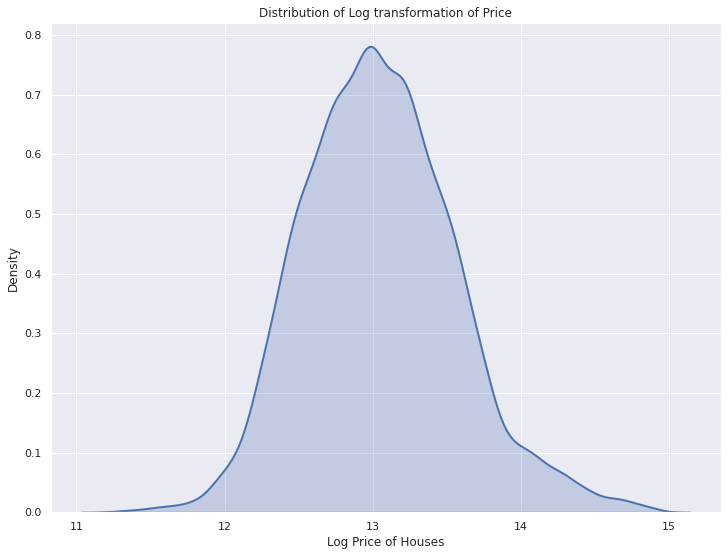

In [ ]:
#presentation style
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(x=df_train['logprice'], shade=True, linewidth=2)
ax.set_title("Distribution of Log transformation of Price")
ax.set_xlabel("Log Price of Houses")

In [ ]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('logprice')
X_train = df_train

y_test = df_test.pop('logprice')
X_test = df_test

In [ ]:
# keep only model features
model_features = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront',  'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'median_household_income']


In [ ]:
# first model with an arbitrary choice of n_features
# keep only model features
model_features = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront',  'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'median_household_income']

gbr = GradientBoostingRegressor(random_state=0)
baseline = gbr.fit(X_train[model_features], y_train)
baseline.get_params(deep=True)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# num of max features to be used in the model is a hyperparameter.
len(X_train[model_features].columns)

12

In [ ]:
# Get predictions for our test data
predictions = gbr.predict(X_test[model_features])
predictions

array([14.56129373, 14.69971604, 14.63694579, ..., 14.70823722,
       14.71404727, 14.60698578])

In [ ]:
# Compute the Root Mean Squared Error of the predictions

log_mse = mean_squared_error(y_test, predictions, squared=False)
print("Log price MSE: %0.3f" %(log_mse))

# Off by log 1.560 on average

Log price MSE: 1.560


In [ ]:
# convert MSE log price to $ price
dollar_mse = np.exp(log_mse)
print("Dollar price mean square error: $%0.3f" %(dollar_mse))


Dollar price mean square error: $4.761


## Cross-Validation

In [ ]:
Cross-Validation

In [ ]:
# create an xgboost regression model
xgb = XGBRegressor()

NameError: ignored

In [ ]:
print(xgboost.__version__)

0.90


## Score New Data

In [ ]:
# save the model to disk
filename = 'finalized_price_model.sav'
pickle.dump(gbr, open(filename, 'wb'))

In [ ]:
# load the model from disk
model_features = ['bedrooms', 'bathrooms','sqft_living', 'sqft_lot', 'floors', 'waterfront', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'median_household_income']

loaded_gbr_model = pickle.load(open(filename, 'rb'))
result = loaded_gbr_model.score(X_test[model_features], y_test)
print(result)


-8.105161444783485
